# Résultats des analyses sur Annonceur1_campagne3_visite_2pages

Nous présentons ici les résultats graphiques et leur analyse pour la campagne mentionnée.

In [1]:
import pandas as pd
from premiere_analyse import *
from testZ import *
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa.stattools as sto
import seaborn as sns

sns.set_style("ticks")

import numpy as np
import scipy.stats as st
%load_ext autoreload
%autoreload 2

In [2]:
#données de la campagne
# folder = 'C:/Users/Admin/Documents/Centrale Paris/3A/OMA/Projet/Donnees/'
folder = 'Data/'
annonceur = 'annonceur1/annonceur1'
campagne = 'annonceur1_campaign3_visite_2pages'
data = pd.read_hdf(folder + annonceur + '.hdf', key=campagne)

Analyse du taux de conversion des versions A et B de la bannière en tant que série temporelle

In [3]:
#préparation des données
dataA, dataB = preparer(data) 

Conversion des index en dates
Moyennes des taux par jour et séparation en deux groupes A et B


La moyenne du taux de conversion global pour les 2 groupes est très similaire :

In [4]:
data.groupby('group')['is_conv'].mean()

group
A    0.000096
B    0.000093
Name: is_conv, dtype: float64

# Visualisation des données brutes

Est-ce qu'il y a un pattern (journalier, hebdomadaire, mensuel, ...) dans le taux de conversion ou la différence relative de taux de conversion ? 

On ajoutera aussi le nombre total de conversions pour la fréquence donnée afin de savoir si une importante différence relative est significative ou pas (si c'est 100% mais pour un 1 vs 2 par exemple).

In [5]:
freq_list = ["1D", "1W"]

conv_rate = {}
pct_change = {}
conv_count = {}

for freq in freq_list:
    conv_count[freq] = conversion_count_resample(data, freq)
    conv_rate[freq] = conversion_rate_resample(data, freq)
    pct_change[freq] = (conv_rate[freq]["A"] - conv_rate[freq]["B"]) / conv_rate[freq]["B"]
    # attention il y a des NaN quand il y a pas de conversion du groupe B

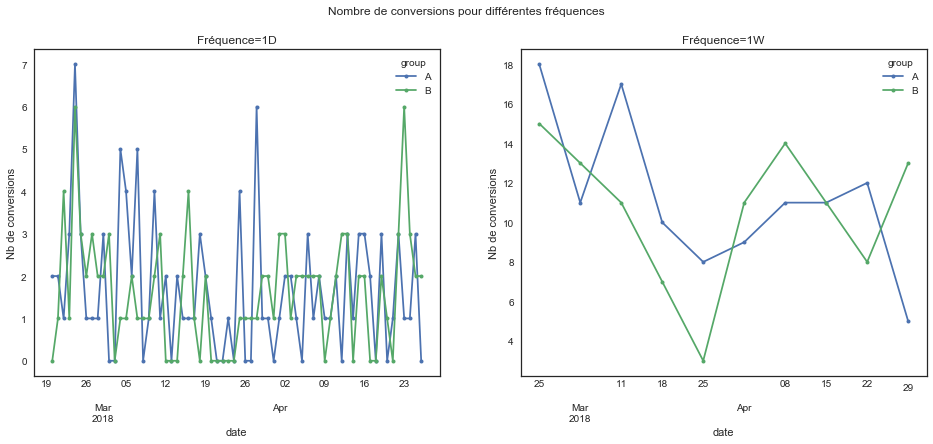

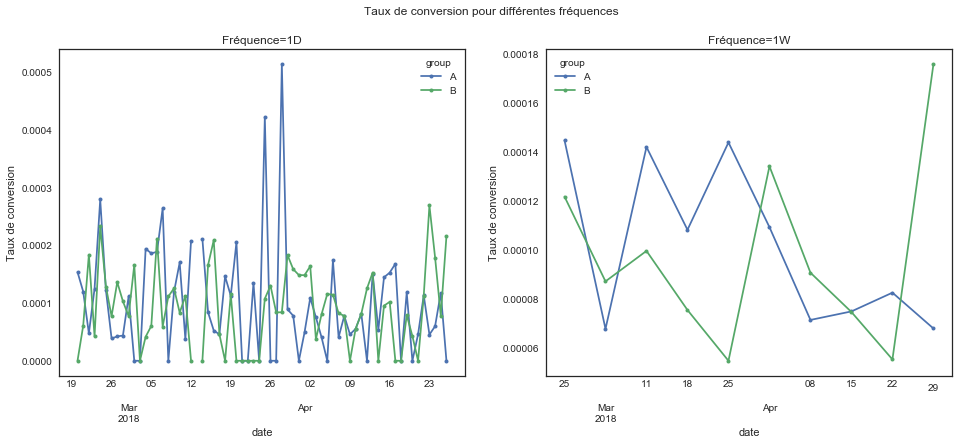

In [6]:
# trace des taux de conversion pour frequences differentes
plt.figure(figsize=(16, 6))
for i, freq in enumerate(freq_list):
    plt.subplot(1, len(freq_list), i+1)
    conv_count[freq].plot(ax=plt.gca(), marker="o", ms=4)
    plt.title(f"Fréquence={freq}")
    plt.ylabel('Nb de conversions')
plt.suptitle('Nombre de conversions pour différentes fréquences')
plt.show()

# trace des taux de conversion pour frequences differentes
plt.figure(figsize=(16, 6))
for i, freq in enumerate(freq_list):
    plt.subplot(1, len(freq_list), i+1)
    conv_rate[freq].plot(ax=plt.gca(), marker="o", ms=4)
    plt.title(f"Fréquence={freq}")
    plt.ylabel('Taux de conversion')
plt.suptitle('Taux de conversion pour différentes fréquences')
plt.show()

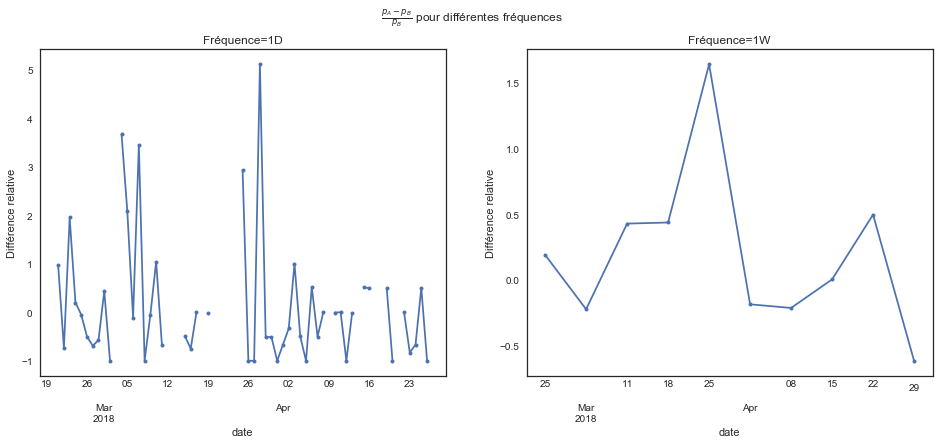

In [7]:
# trace des variations relatives pour frequences differentes
plt.figure(figsize=(16, 6))
for i, freq in enumerate(freq_list):
    plt.subplot(1, len(freq_list), i+1)
    pct_change[freq].plot(ax=plt.gca(), marker="o", ms=4)
    plt.title(f"Fréquence={freq}")
    plt.ylabel('Différence relative')
plt.suptitle('$\\frac{p_A - p_B}{p_B}$ pour différentes fréquences')
plt.show()

Dans l'ensemble il n'y a pas de tendance marquante permettant de distinguer le groupe A du groupe B quel que soit l'échelle considérée pour ce dataset. La différence relative est difficilement exploitable car les taux de conversion peuvent valoir 0 pour les deux groupes.

En revanche, le changement de fréquence permet un lissage des données avec moins de variance mais le nombre de données devient très faible. Peut-être considérer un lissage sur une période glissante de 3 à 5 jours ?

# Test Z

## Test Z global

Enfin, on conduit un Z-test destiné à mesurer l'efficacité statistique du test A/B mené. Mathématiquement, cela se traduit par la comparaison de l'hypothèse nulle H0 : "le taux de conversion sous version A est le même que celui sous version B" avec l'hypothèse H1 : "le taux de conversion sous version A est différent que celui sous version B". 

Pour ce faire, on utilise l'**ensemble des données** (du début jusqu'à la fin de la campagne) du dataset pour réaliser le test qui nous donnera une statistique qui nous permettra de calculer la p-valeur i.e. la probabilité de rejeter l'hypothèse nulle H0, à l'issue de toute la durée de la campagne.

In [8]:
Z, Prej = testZ(data)
print('Zstat = {0:.3}, Pval={1:.3}'.format(Z, Prej))

Zstat = 0.254, Pval=0.8


La Pval étant de 0.8, on ne peut donc pas rejeter l'hypothèse nulle avec un seuil de confiance classique (5%, 1%).

Conclusion : à l'issue toute la campagne, aucune des deux versions n'est meilleure que l'autre en termes de taux de conversion journalier.

## Test Z cumulé

Est-ce que le Z-test aurait donné des résultats différents si l'on a arrêté le test A/B à des instants plus tôt ? 

On s'intéresse maintenant aux **données cumulées** : en regardant l'ensemble des informations dont on dispose du jour 1 de la campagne publicitaire au jour n, peut-on voir une certaine tendance quant au test d'hypothèses ? Est-ce que si l'on avait arrêté le test plus tôt les résultats auraient été différents ?

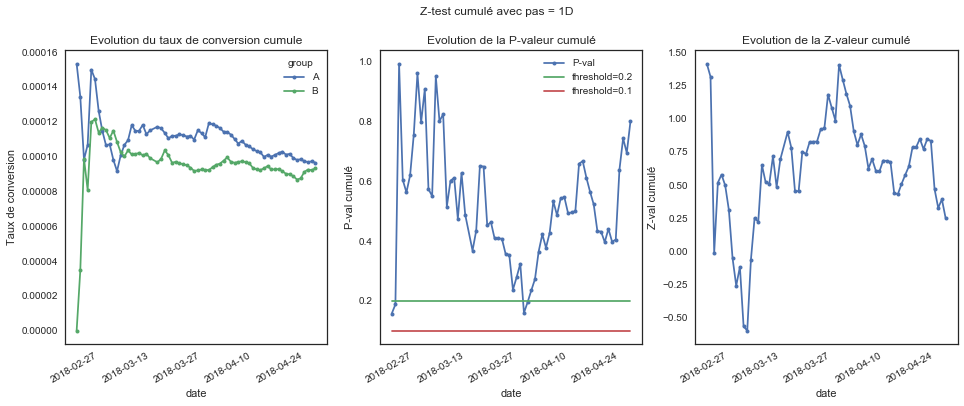

In [9]:
freq = "1D"
Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq=freq)
plot_testZ_cum_frequency(Z_cum, P_rej, p_cum, freq)

Les résultats du Z test sont  différents en fonction de l'instant considéré : si on s'était arrêté vers fin Mars on aurait pu rejeter H0 avec un taux de confiance de 20% et dire que A est meilleur. Mais, dans tous les cas, on est au-dessus de la p-valeur de 10% et quasiment tout le temps au-dessus de 20% :  il n'y a pas de variation de la significativité du test et on ne peut pas conclure pour ces niveaux de confiance que les deux versions sont différentes.

Est-ce que la réalisation du testZ cumulé avec un pas de plusieurs jours donnerait de meilleurs résultats ? On fait un test Z avec les données de t0 à t0 + pas, puis t0 à t0 + 2pas...

/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


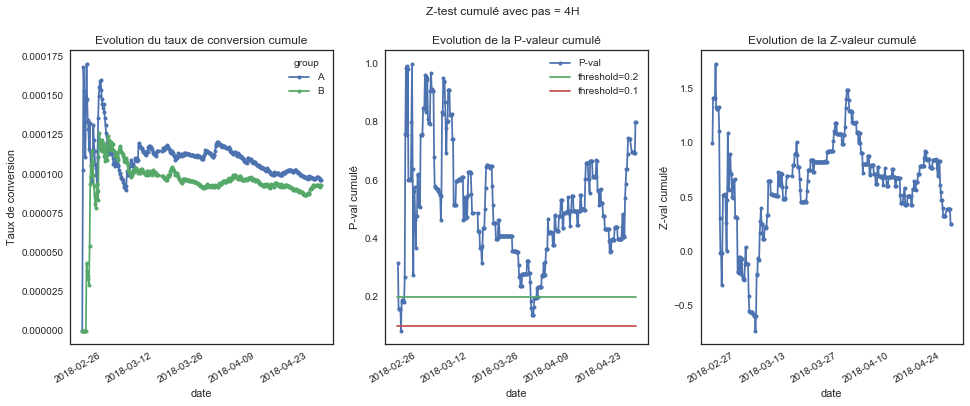

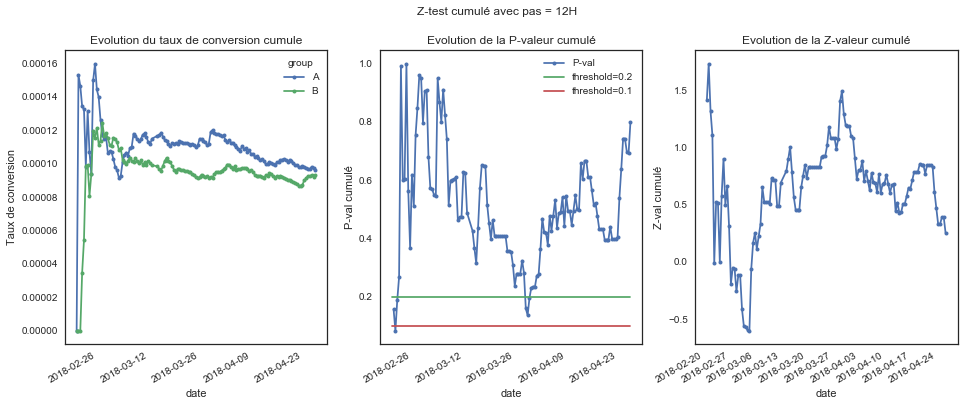

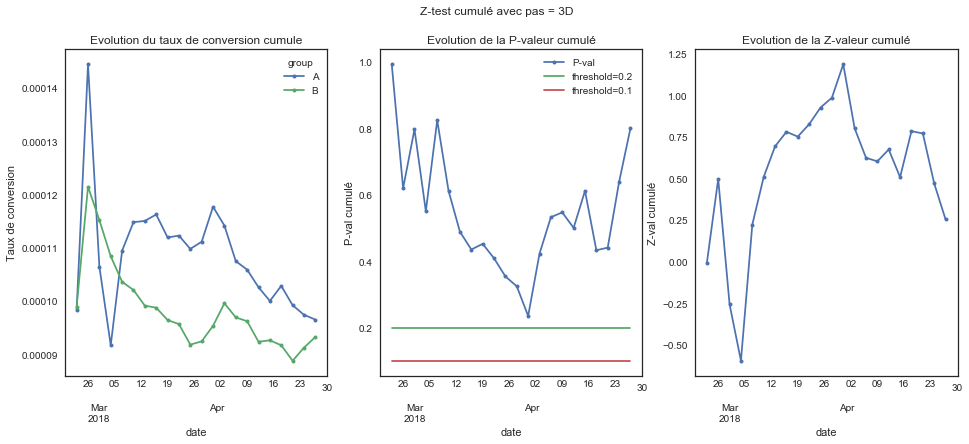

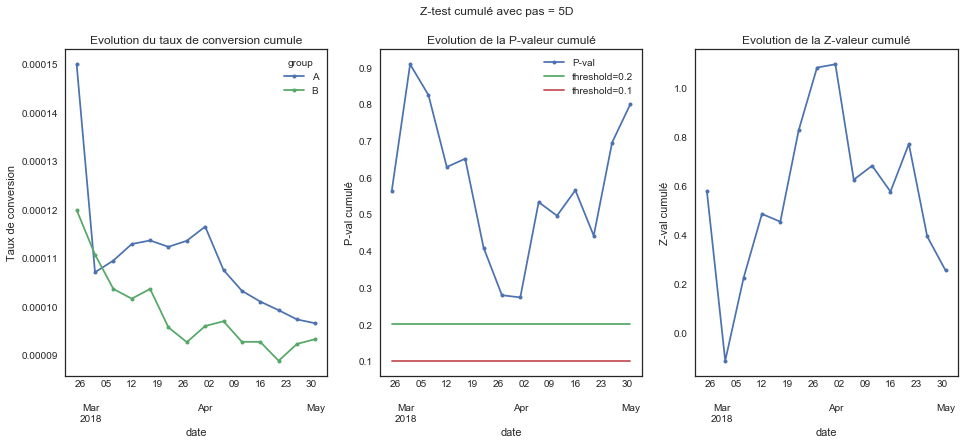

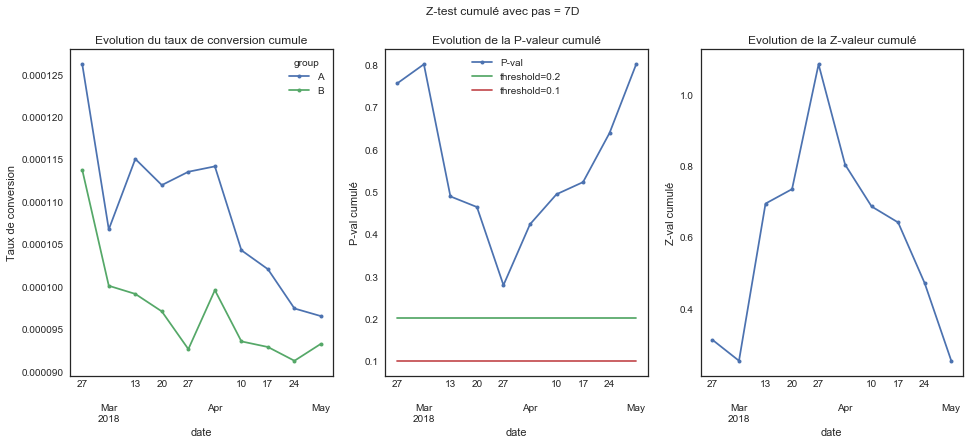

In [12]:
for freq in ["4H", "12H", "3D", "5D", "7D"]:  # 1W does not work but 7D is ok
    Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq=freq)
    plot_testZ_cum_frequency(Z_cum, P_rej, p_cum, freq)

/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


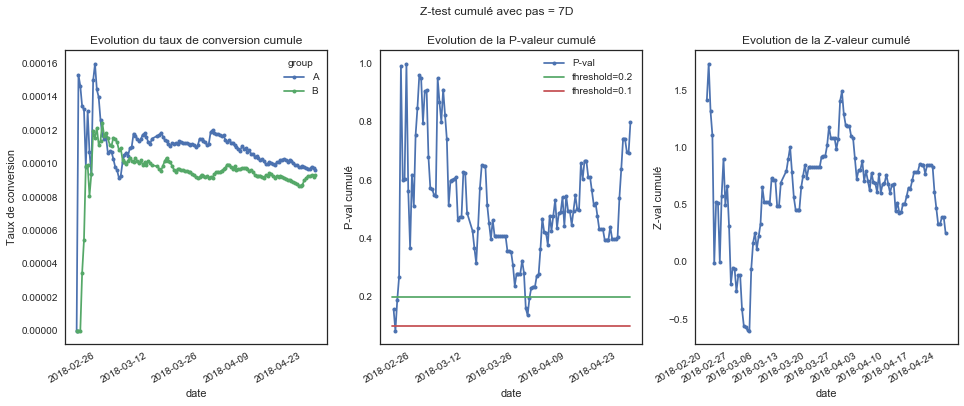

In [15]:
Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq="12H")
plot_testZ_cum_frequency(Z_cum, P_rej, p_cum, freq)

Conclusion : 

Avec des pas de 4H, 12H, 3, 5 et 7 jours, la conclusion reste la même, aucune version n'est meilleure.

Il serait peut-être intéressant d'étudier la stationnarité de la série des Pval ou de la valeur Z.  

# Stationnarité des taux de conversion

## Groupe A

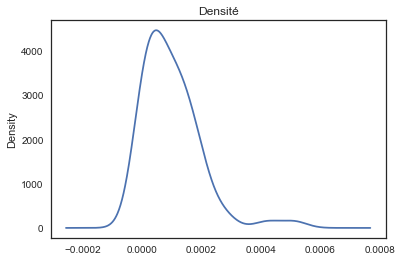

## Analyse classique d'une ST

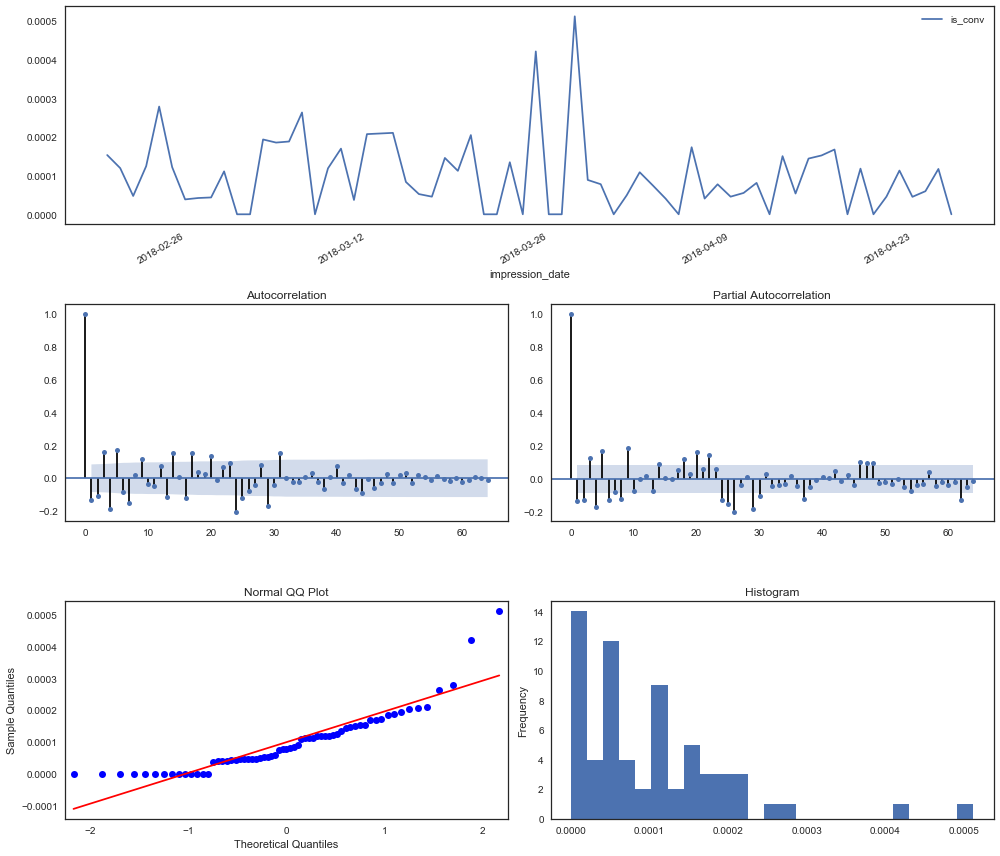

## Effet journalier

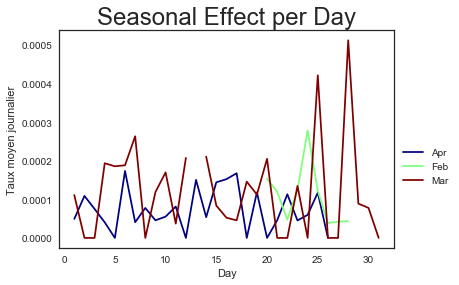

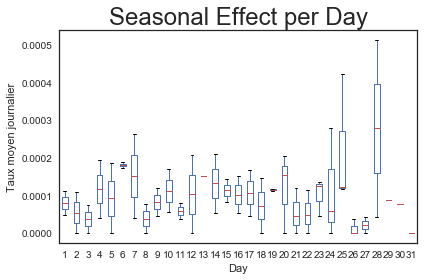

## Décomposition de la série de temps selon modèle multiplicatif



Multiplicative seasonality is not appropriate for zero and negative values


## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-8.966872e+00
p-value,7.945456e-15
# of lags,0.000000e+00
# of observations,6.400000e+01
Critical Value (1%),-3.536928e+00
Critical Value (5%),-2.907887e+00
Critical Value (10%),-2.591493e+00


In [4]:
analyser(dataA)

Différencier à l'ordre 1: y_t - y_[t-1]
Analyse après transformation



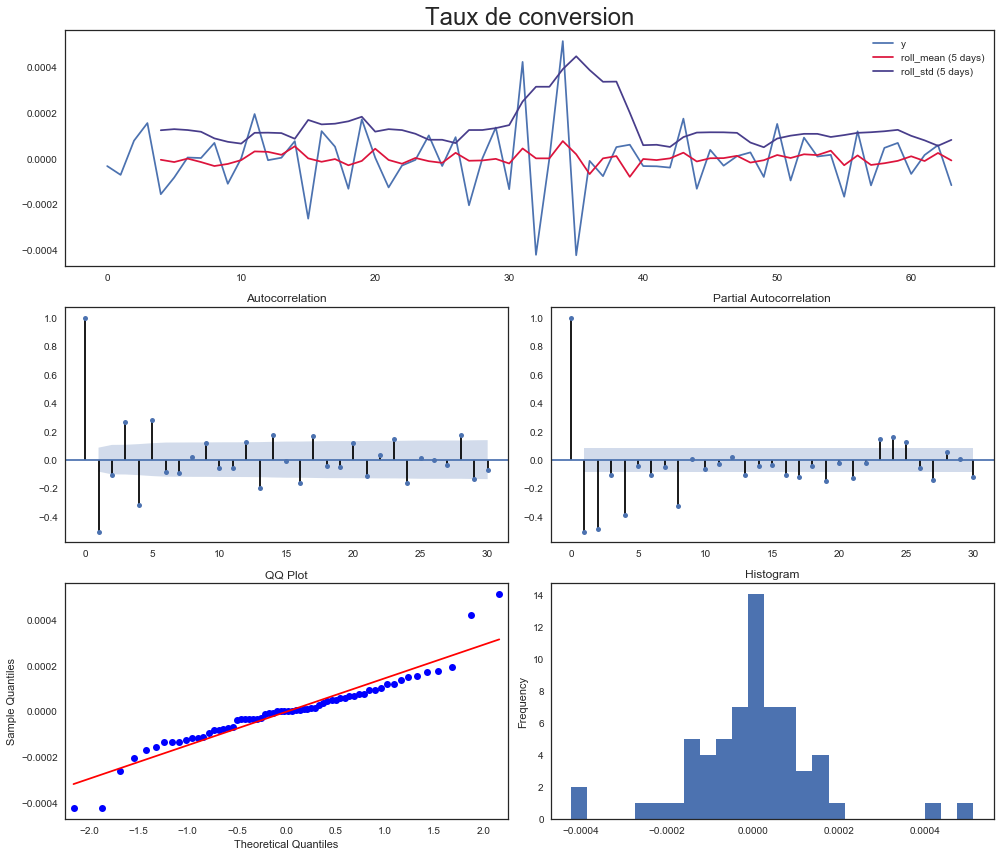

,Results of Augmented Dickey-Fuller test:
test statistic,-7.740512e+00
p-value,1.065030e-11
# of lags,3.000000e+00
# of observations,6.000000e+01
Critical Value (1%),-3.544369e+00
Critical Value (5%),-2.911073e+00
Critical Value (10%),-2.593190e+00


In [5]:
transformer(dataA,"diff1")

## Groupe B

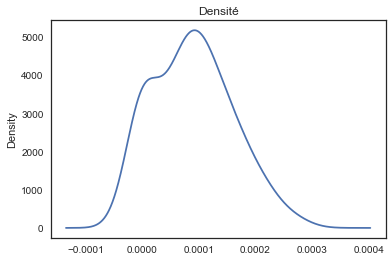

## Analyse classique d'une ST

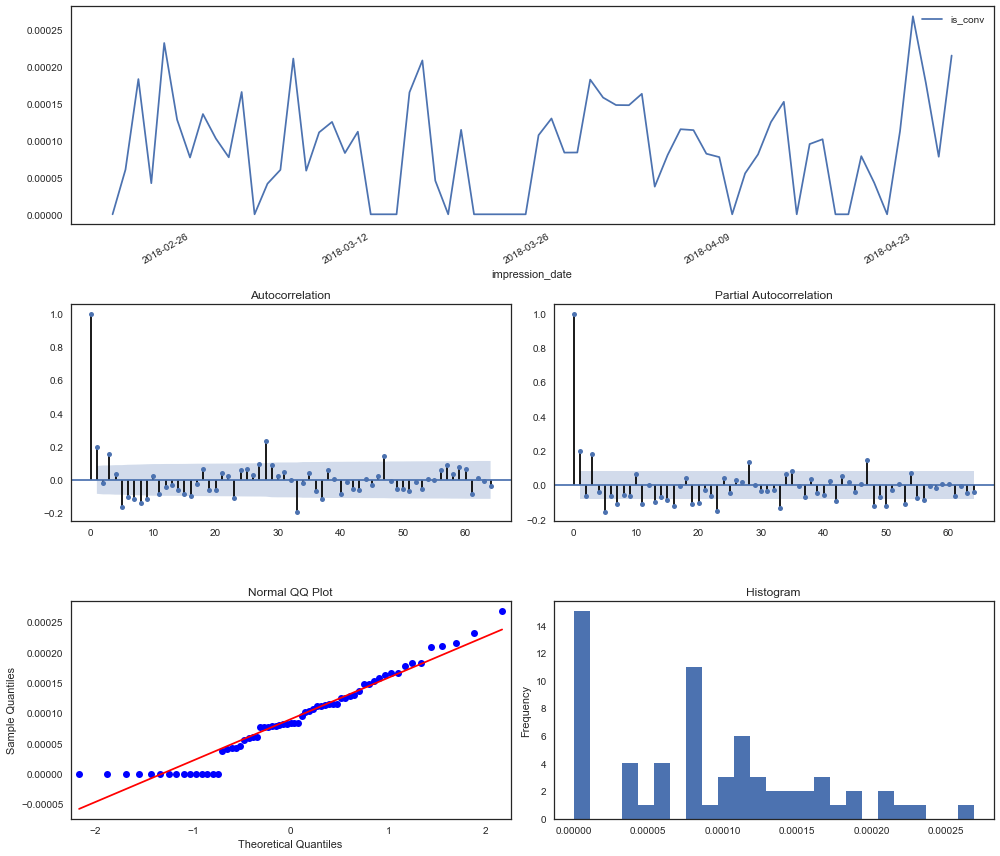

## Effet journalier

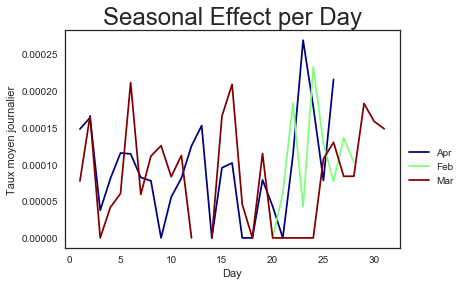

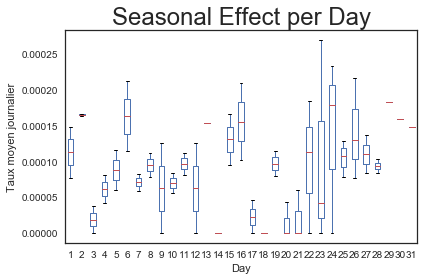

## Décomposition de la série de temps selon modèle multiplicatif



Multiplicative seasonality is not appropriate for zero and negative values


## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-3.174044
p-value,0.021537
# of lags,4.000000
# of observations,60.000000
Critical Value (1%),-3.544369
Critical Value (5%),-2.911073
Critical Value (10%),-2.593190


In [6]:
analyser(dataB)

Différencier à l'ordre 1: y_t - y_[t-1]
Analyse après transformation



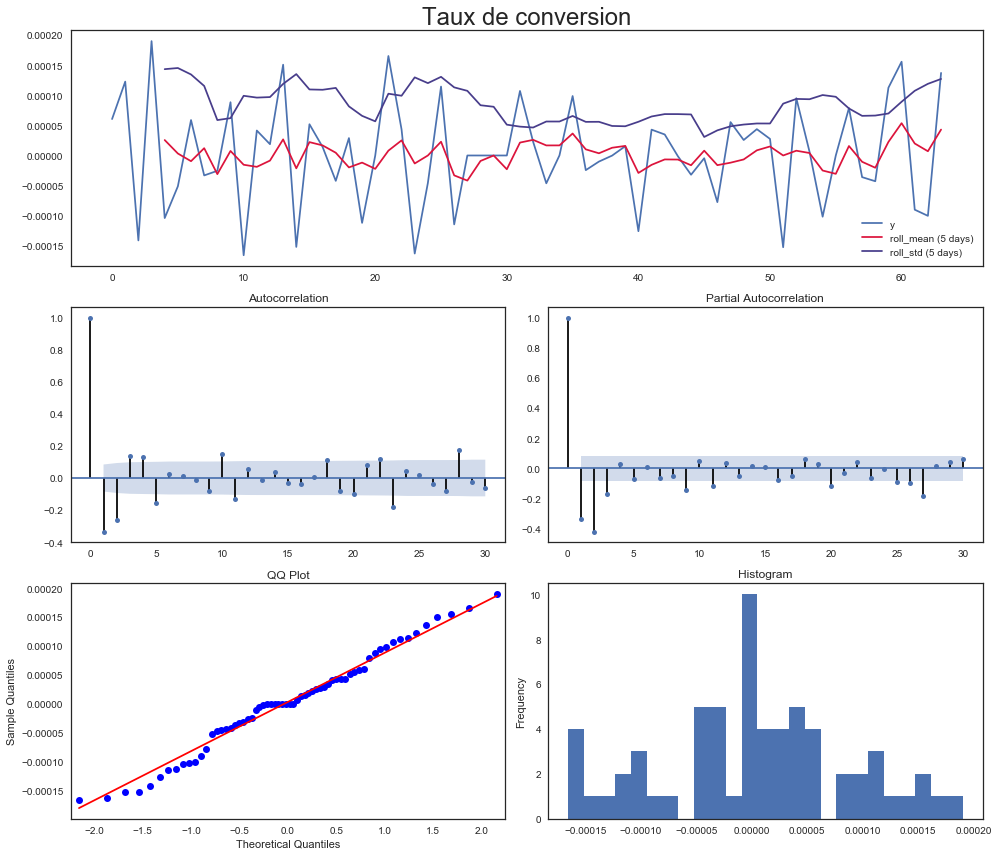

,Results of Augmented Dickey-Fuller test:
test statistic,-7.130671e+00
p-value,3.524617e-10
# of lags,2.000000e+00
# of observations,6.100000e+01
Critical Value (1%),-3.542413e+00
Critical Value (5%),-2.910236e+00
Critical Value (10%),-2.592745e+00


In [7]:
transformer(dataB,"diff1")

# Modèles ARMA

Afin de prédire la série des Z-valeurs ou celle des p-valeurs, dans cette partie, nous allons voir s'il est possible de trouver un modèle ARMA(p, q) correspondant bien à l'ensemble des données. Nous jugerons les performances via les critères AIC, BIC ainsi que sur les prévisions in-sample à partir de la moitié ou des 3/4 des données.

In [57]:
Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq='1D')

### a. Etude sur Z

## Analyse classique d'une ST

/anaconda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


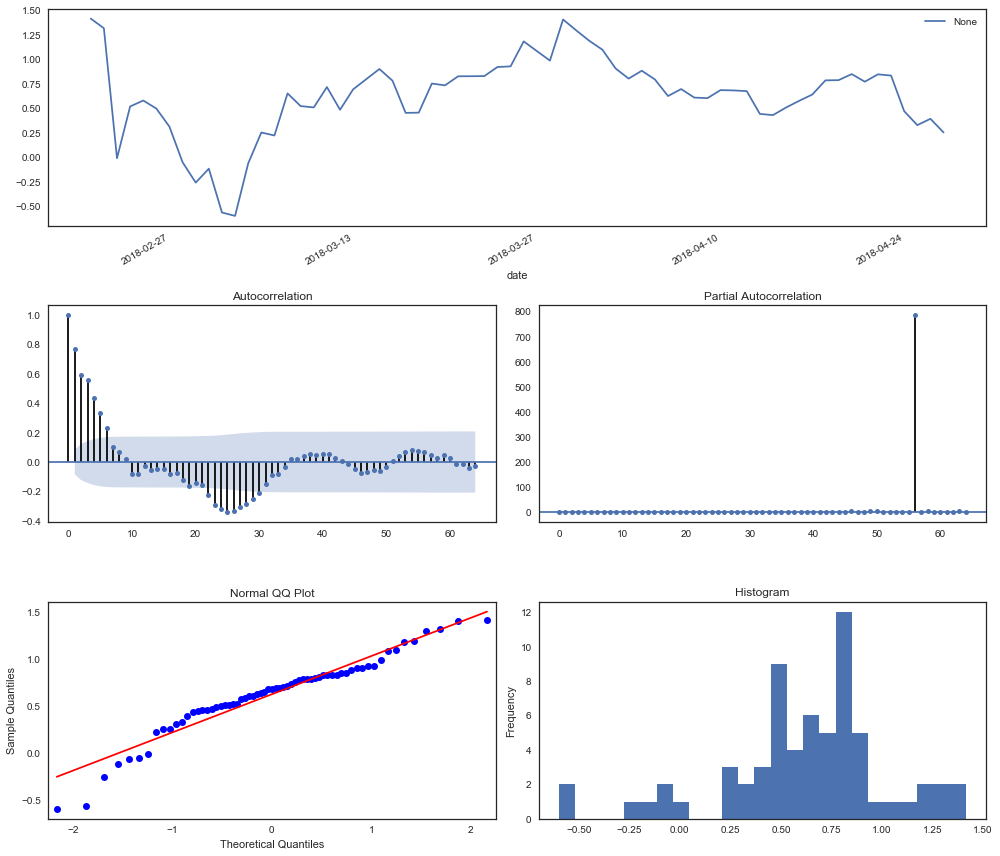

## Décomposition de la série de temps selon modèle multiplicatif



Multiplicative seasonality is not appropriate for zero and negative values


## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-2.946244
p-value,0.040229
# of lags,0.000000
# of observations,64.000000
Critical Value (1%),-3.536928
Critical Value (5%),-2.907887
Critical Value (10%),-2.591493


In [58]:
series = Z_cum
analyserZP(series)

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


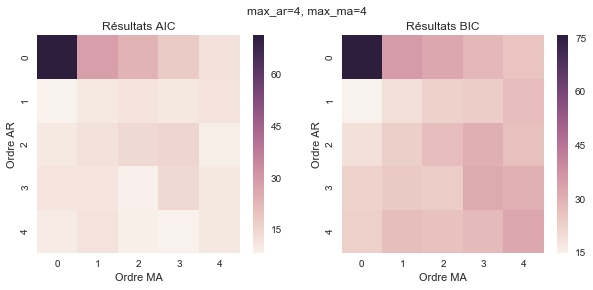

AIC meilleur modèle : AR=4, MA=3, AIC=8.165326601084388 
BIC meilleur modèle : AR=1, MA=0, BIC=14.791940670464697 


In [59]:
##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = arma_model_selection(series, max_ar=max_ar, max_ma=max_ma)
aic_min_order = order_select["aic_min_order"]
bic_min_order = order_select["bic_min_order"]

# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   65
Model:                     ARMA(4, 3)   Log Likelihood                   4.917
Method:                       css-mle   S.D. of innovations              0.216
Date:                Mon, 04 Feb 2019   AIC                              8.165
Time:                        21:51:37   BIC                             27.735
Sample:                             0   HQIC                            15.887
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6789      0.044     15.268      0.000       0.592       0.766
ar.L1.y        0.7479      0.101      7.371      0.000       0.549       0.947
ar.L2.y        0.2146      0.121      1.778      0.0

## Erreurs sur la période d'entraînement

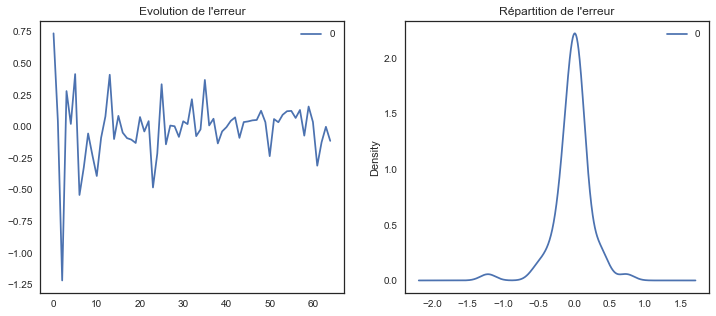

# Meilleur modèle selon BIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   65
Model:                     ARMA(1, 0)   Log Likelihood                  -1.134
Method:                       css-mle   S.D. of innovations              0.244
Date:                Mon, 04 Feb 2019   AIC                              8.269
Time:                        21:51:38   BIC                             14.792
Sample:                             0   HQIC                            10.843
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6488      0.154      4.221      0.000       0.348       0.950
ar.L1.y        0.8146      0.074     10.977      0.000       0.669       0.960
                                    Roots           

## Erreurs sur la période d'entraînement

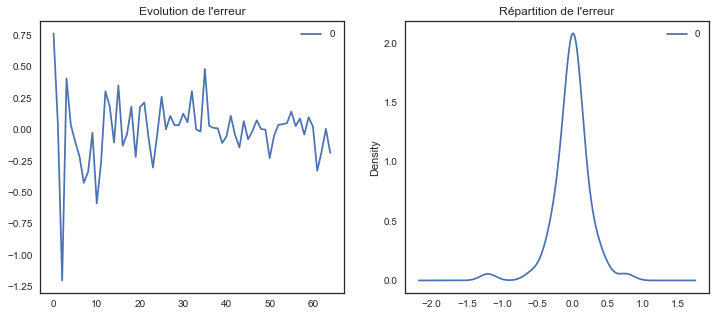

In [60]:
display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)

### Zoom sur un modèle en particulier

Pour un modèle donné, est-ce que ce modèle est pertinent ? Regarder les p-valeurs des coefficients. 

Dans cette section on a construit le modèle à partir de l'ensemble des données. Mais quelles sont les prévisions selon le modèle sur les données existantes (in-sample)? 
On réalise des prédictions de `pred_start` à `pred_end` (None donne la fin de la période)
On peut distinguer deux types de prévisions : 
+ 1-step-ahead : on utilise toutes les données jusqu'à J-1
+ Dynamic : à partir de pred_start on utilise les variables prédites comme entrées
    + C'est ce mode qui nous intéresse car on aimerait faire des prédictions pour des horizons lointains sans avoir à faire le test A/B en réel

train_ratio= 0.25


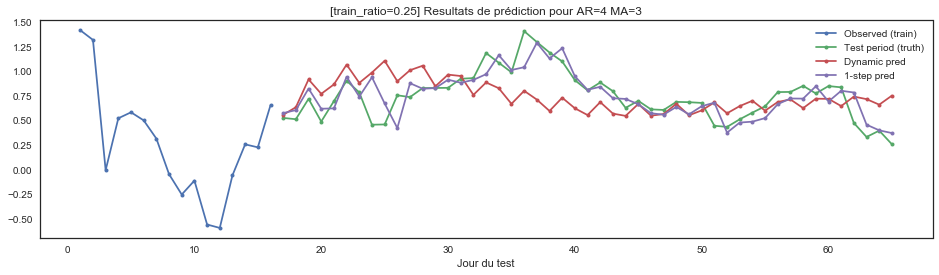

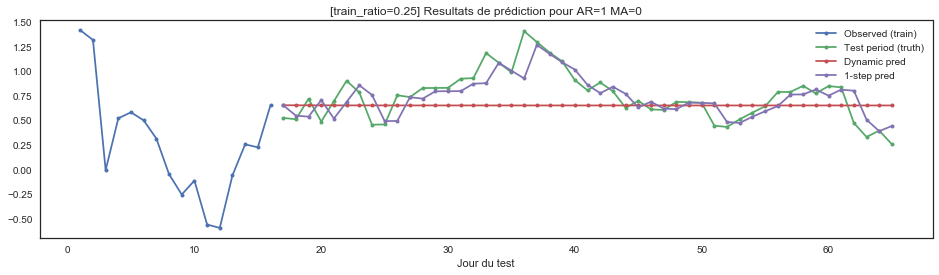

train_ratio= 0.5


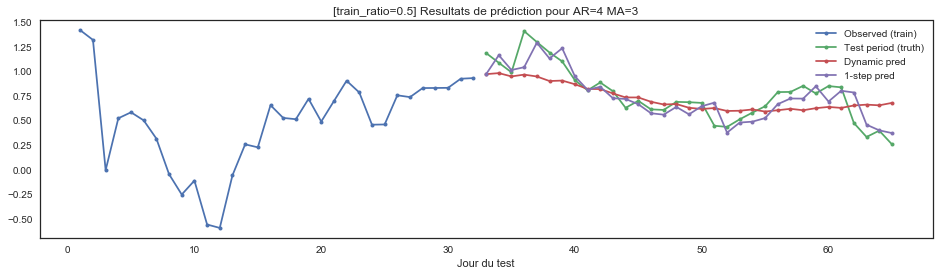

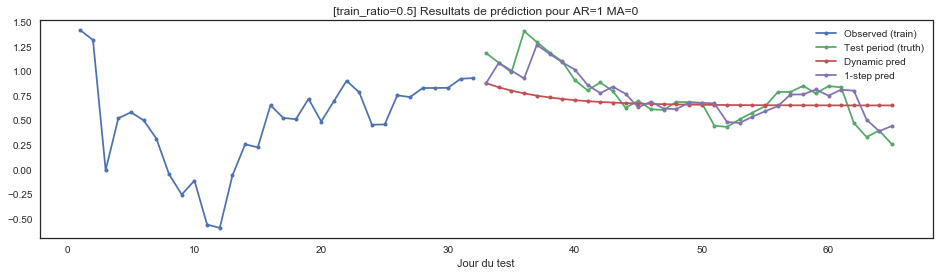

train_ratio= 0.75


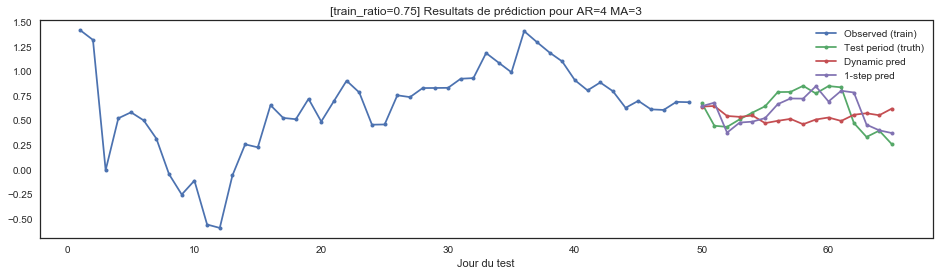

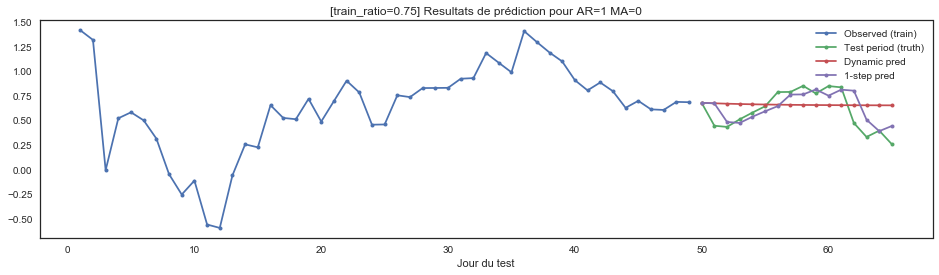

In [61]:
for train_ratio in [0.25, 0.5, 0.75]:
    print("train_ratio=", train_ratio)
    in_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values, train_ratio=train_ratio)
    if aic_min_order != bic_min_order:    
        in_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values, train_ratio=train_ratio)

> Dans l'ensemble, les prévisions dynamiques peuvent capturer une partie des fluctuations des données, mais c'est pas terrible non plus. Il reste à savoir à quel point cela est exploitable, car ici on a pris toutes les données pour entraîner le modèle, incluant celles de la période test, on est en quelque sorte en train d'étudier la borne supérieure de la performance du modèle.

### b. Etude sur p

## Analyse classique d'une ST

/anaconda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


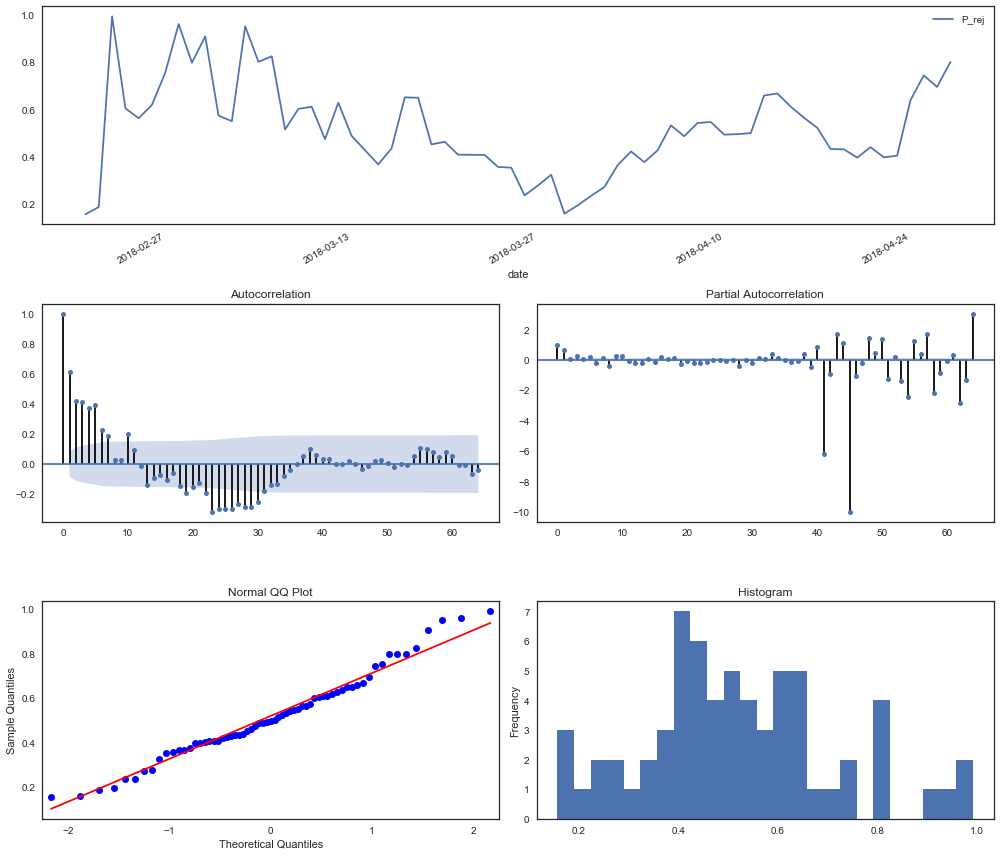

## Décomposition de la série de temps selon modèle multiplicatif

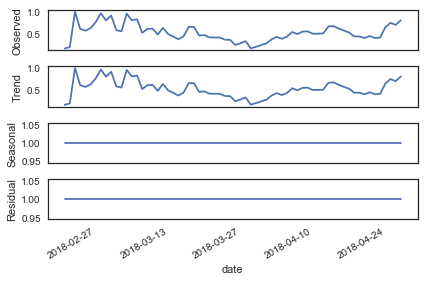

## Test de Dickey-Fuller

,Results of Augmented Dickey-Fuller test:
test statistic,-1.913849
p-value,0.325574
# of lags,11.000000
# of observations,53.000000
Critical Value (1%),-3.560242
Critical Value (5%),-2.917850
Critical Value (10%),-2.596796


/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:

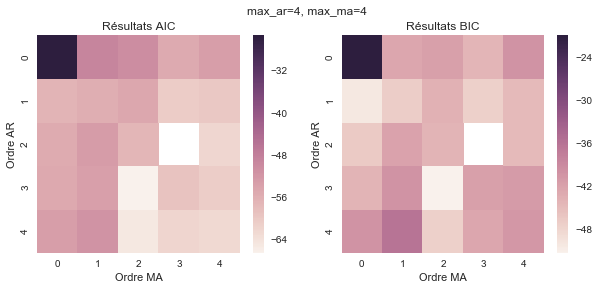

AIC meilleur modèle : AR=3, MA=2, AIC=-66.5984921561512 
BIC meilleur modèle : AR=3, MA=2, BIC=-51.37778126688174 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   65
Model:                     ARMA(3, 2)   Log Likelihood                  40.299
Method:                       css-mle   S.D. of innovations              0.126
Date:                Mon, 04 Feb 2019   AIC                            -66.598
Time:                        21:52:11   BIC                            -51.378
Sample:                             0   HQIC                           -60.593
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5164      0.060      8.660      0.000       0.399       0.633
ar.L1.y       -0.9138      0.100     -9.097      0.000      -1.111      -0.717
ar.L2.y        0.2929      0.150      1.959      0.0

## Erreurs sur la période d'entraînement

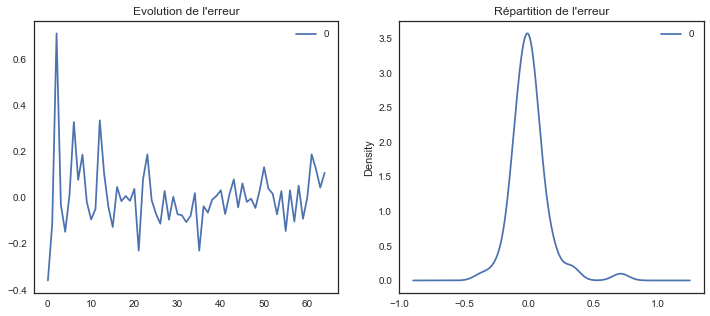

train_ratio= 0.25


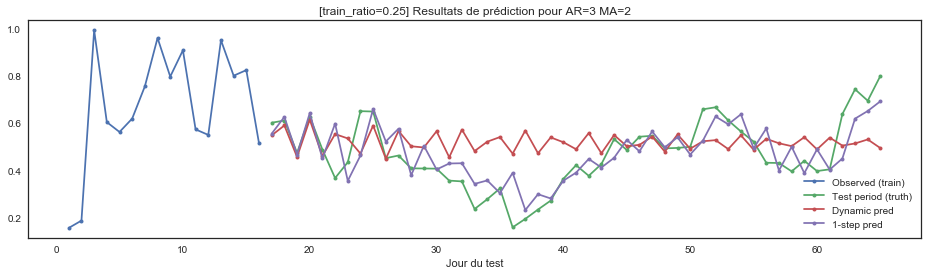

train_ratio= 0.5


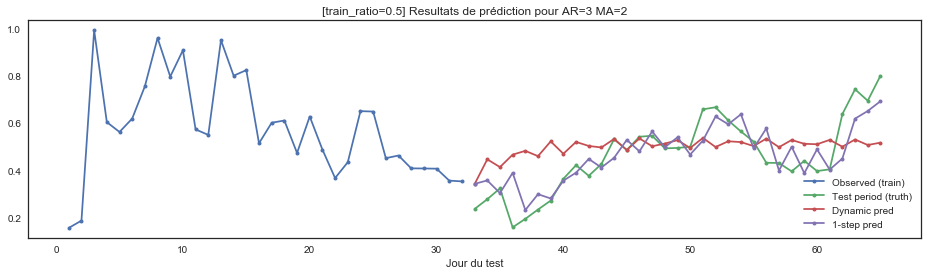

train_ratio= 0.75


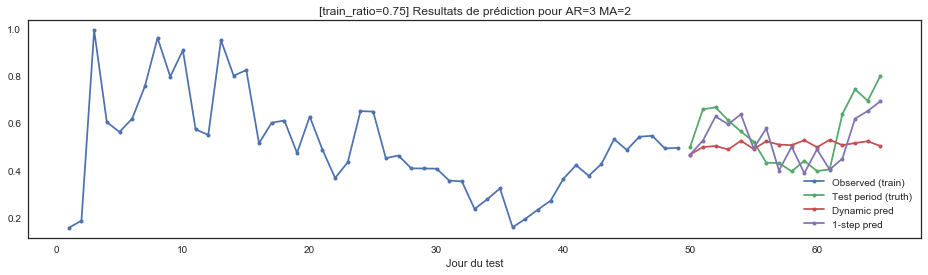

In [62]:
series = P_rej
analyserZP(series)

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
train_ratio_list = [0.25, 0.5, 0.75]
######################################################################################

order_select = arma_model_selection(series, max_ar=max_ar, max_ma=max_ma)
aic_min_order = order_select["aic_min_order"]
bic_min_order = order_select["bic_min_order"]

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
for train_ratio in train_ratio_list:
    print("train_ratio=", train_ratio)
    in_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values, train_ratio=train_ratio)
    if aic_min_order != bic_min_order:
        in_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values, train_ratio=train_ratio)    

## Fit sur modèle tronqué

Si les résultats en fittant sur l'ensemble des données donnent des prévisions in-sample encore acceptables, nous nous intéressons aux prévisions out-of-sample à présent, si les résultats sont bons cela nous permettra de pouvoir arrêter les tests A/B plus tôt. Nous allons prendre 50% et 75% des données et observer la performance sur les modèles ARMA.

### train_ratio = 0.5

Si on entraîne sur la moitié des données (`train_ratio=0.5`), est-il possible d'avoir quand même un modèle permettant de prédire de manière convaincante la série des Z-valeurs ou des p-valeurs ?. 

In [63]:
Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq='1D')
train_ratio = 0.5
t = round(train_ratio * len(Z_cum))
Z_tronq = Z_cum.iloc[0:t]
P_tronq = P_rej.iloc[0:t]

#### a. Etude sur Z

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (

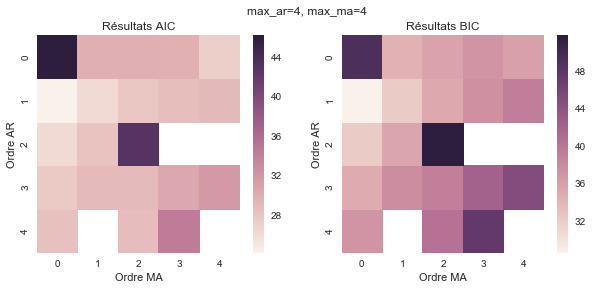

AIC meilleur modèle : AR=1, MA=0, AIC=24.148845281569322 
BIC meilleur modèle : AR=1, MA=0, BIC=28.5460529899685 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   32
Model:                     ARMA(1, 0)   Log Likelihood                  -9.074
Method:                       css-mle   S.D. of innovations              0.317
Date:                Mon, 04 Feb 2019   AIC                             24.149
Time:                        21:52:31   BIC                             28.546
Sample:                             0   HQIC                            25.606
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6005      0.230      2.615      0.014       0.150       1.050
ar.L1.y        0.7682      0.120      6.400      0.000       0.533       1.003
                                    Roots           

## Erreurs sur la période d'entraînement

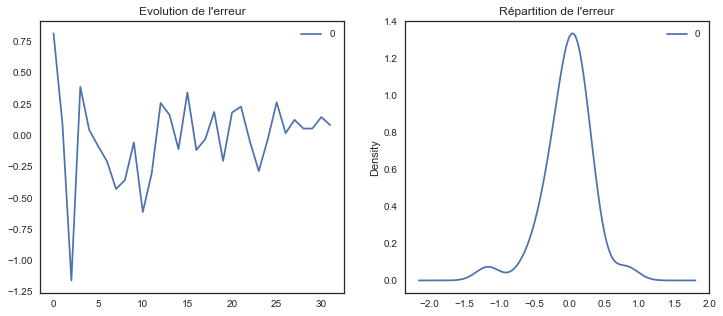

/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


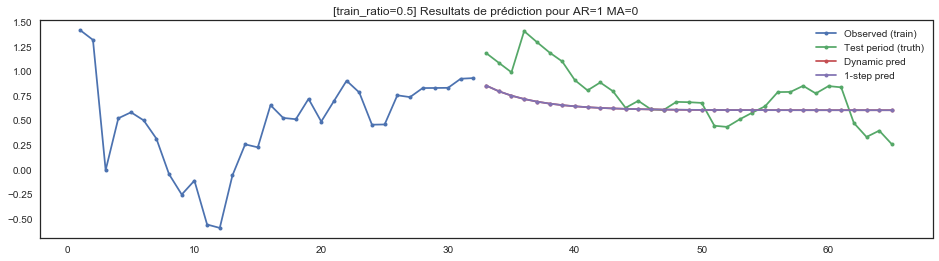

In [64]:
series = Z_tronq
y_true = Z_cum

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = arma_model_selection(series, max_ar=max_ar, max_ma=max_ma)
aic_min_order = order_select["aic_min_order"]
bic_min_order = order_select["bic_min_order"]

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true, train_ratio=train_ratio)

#### b. Etude sur p

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tools/numdif

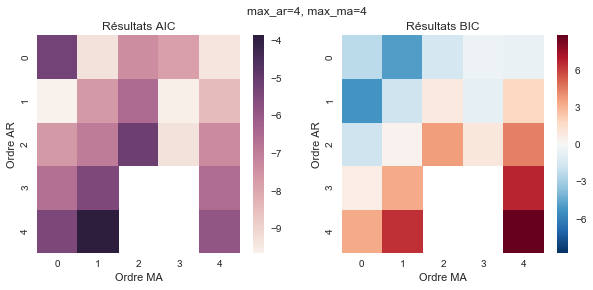

AIC meilleur modèle : AR=1, MA=0, AIC=-9.649166876321829 
BIC meilleur modèle : AR=1, MA=0, BIC=-5.251959167922649 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   32
Model:                     ARMA(1, 0)   Log Likelihood                   7.825
Method:                       css-mle   S.D. of innovations              0.189
Date:                Mon, 04 Feb 2019   AIC                             -9.649
Time:                        21:52:57   BIC                             -5.252
Sample:                             0   HQIC                            -8.192
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5623      0.061      9.242      0.000       0.443       0.682
ar.L1.y        0.4572      0.170      2.690      0.012       0.124       0.790
                                    Roots           

## Erreurs sur la période d'entraînement

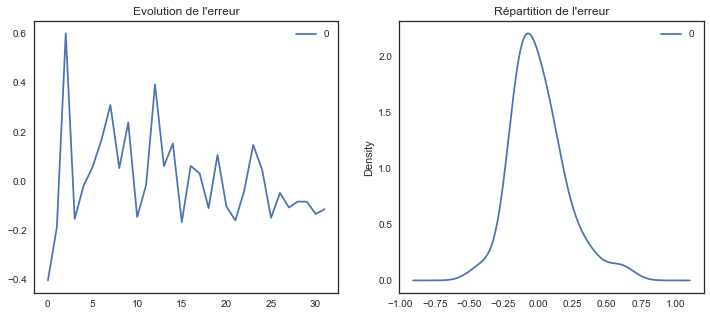

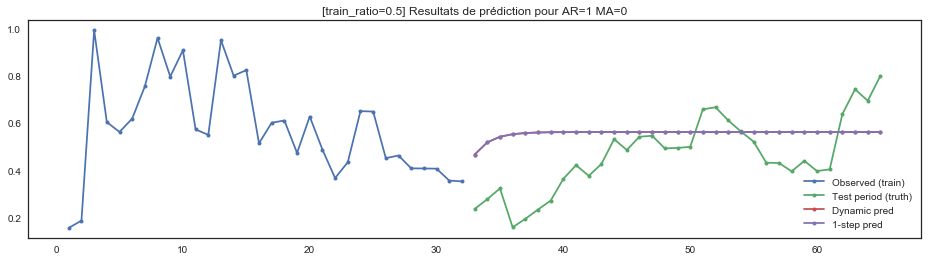

In [65]:
series = P_tronq
y_true = P_rej

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = arma_model_selection(series, max_ar=max_ar, max_ma=max_ma)
aic_min_order = order_select["aic_min_order"]
bic_min_order = order_select["bic_min_order"]

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)

### train_ratio = 0.75
On entraîne sur 75% des données (`train_ratio=0.75`). 

In [66]:
Z_cum, P_rej, p_cum = testZ_cum_frequency(data, freq='1D')
train_ratio = 0.75
t = round(train_ratio * len(Z_cum))
Z_tronq = Z_cum[0:t]
P_tronq = P_rej[0:t]

#### a. Etude sur Z

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda/lib/python3.6

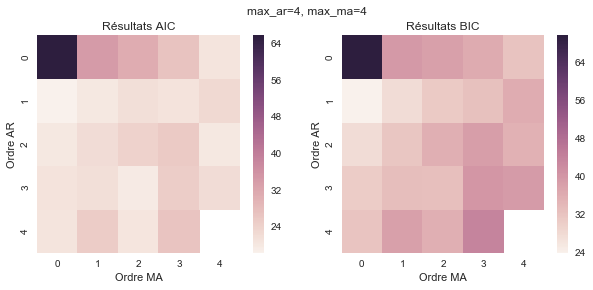

AIC meilleur modèle : AR=1, MA=0, AIC=18.16919930193599 
BIC meilleur modèle : AR=1, MA=0, BIC=23.844660196267867 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   49
Model:                     ARMA(1, 0)   Log Likelihood                  -6.085
Method:                       css-mle   S.D. of innovations              0.271
Date:                Mon, 04 Feb 2019   AIC                             18.169
Time:                        21:53:26   BIC                             23.845
Sample:                             0   HQIC                            20.322
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6935      0.190      3.645      0.001       0.321       1.066
ar.L1.y        0.8101      0.083      9.705      0.000       0.646       0.974
                                    Roots           

## Erreurs sur la période d'entraînement

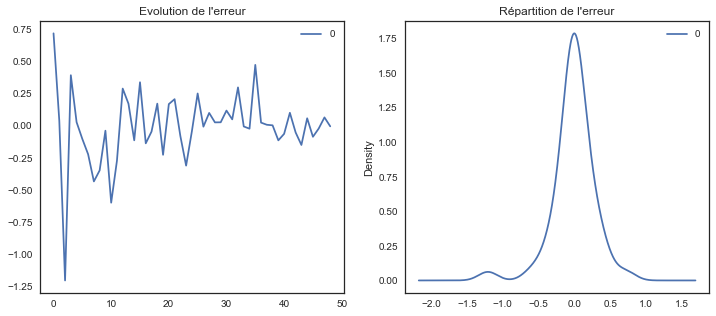

/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


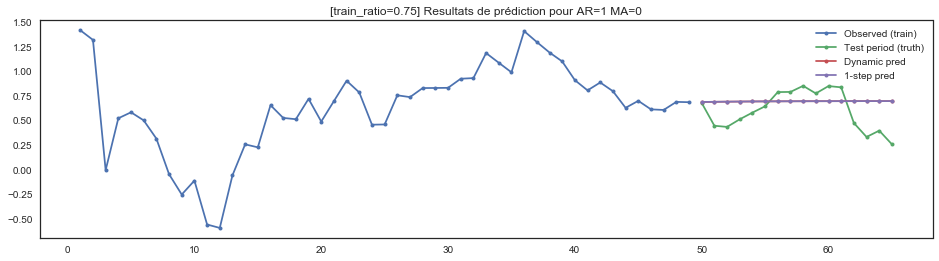

In [67]:
series = Z_tronq
y_true = Z_cum

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = arma_model_selection(series, max_ar=max_ar, max_ma=max_ma)
aic_min_order = order_select["aic_min_order"]
bic_min_order = order_select["bic_min_order"]

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true, train_ratio=train_ratio)

#### b. Etude sur p

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/anaconda/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py

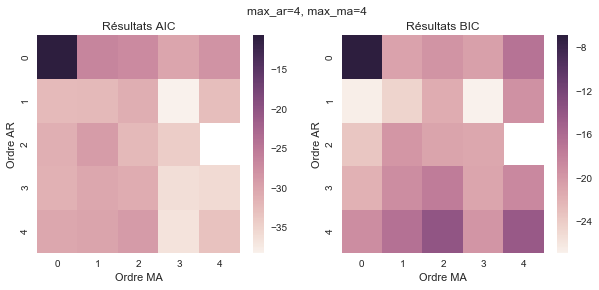

AIC meilleur modèle : AR=1, MA=3, AIC=-38.24927690093807 
BIC meilleur modèle : AR=1, MA=3, BIC=-26.898355112274313 


# Meilleur modèle selon AIC

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   49
Model:                     ARMA(1, 3)   Log Likelihood                  25.125
Method:                       css-mle   S.D. of innovations              0.142
Date:                Mon, 04 Feb 2019   AIC                            -38.249
Time:                        21:53:59   BIC                            -26.898
Sample:                             0   HQIC                           -33.943
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4917      0.084      5.851      0.000       0.327       0.656
ar.L1.y        0.8325      0.114      7.322      0.000       0.610       1.055
ma.L1.y       -0.3902      0.146     -2.673      0.0

## Erreurs sur la période d'entraînement

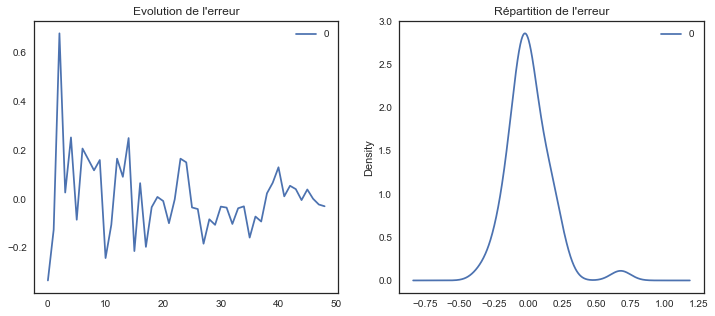

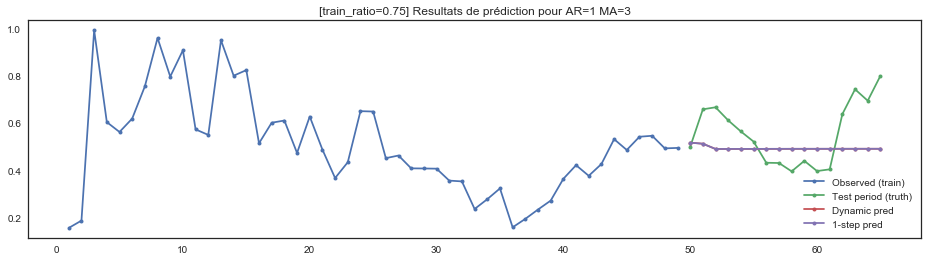

In [68]:
series = P_tronq
y_true = P_rej

##################################### PARAMETRES #####################################
max_ar = 4
max_ma = 4
######################################################################################

order_select = arma_model_selection(series, max_ar=max_ar, max_ma=max_ma)
aic_min_order = order_select["aic_min_order"]
bic_min_order = order_select["bic_min_order"]

display(Markdown("# Meilleur modèle selon AIC"))
arma_summary(p=aic_min_order[0], q=aic_min_order[1], y_true=series.values)
if aic_min_order != bic_min_order:  
    display(Markdown("# Meilleur modèle selon BIC"))
    arma_summary(p=bic_min_order[0], q=bic_min_order[1], y_true=series.values)
    
out_of_sample_prediction(p=aic_min_order[0], q=aic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)
if aic_min_order != bic_min_order:  
    out_of_sample_prediction(p=bic_min_order[0], q=bic_min_order[1], y_true=y_true.values, train_ratio=train_ratio)

> Visuellement, les résultats semblent dans l'ensemble assez moyens en prenant qu'une seule partie des données. Il reste à étudier de manière statistiquement plus rigoureuse ces résultats.